In [42]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from keras.applications import MobileNet
from keras.models import load_model, Model
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image # type: ignore
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

In [20]:
# File Directory for both the train and test
train_path = "chest-ctscan-images/Data/train"
val_path = "chest-ctscan-images/Data/valid"
test_path = "chest-ctscan-images/Data/test"

In [21]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)))
    return num_of_image

train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'normal': 148, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155} 

 {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'normal': 13, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15} 

 {'adenocarcinoma': 120, 'large.cell.carcinoma': 51, 'normal': 54, 'squamous.cell.carcinoma': 90}


In [22]:
train_datagen = image.ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=0.4
)
train_data = train_datagen.flow_from_directory(
    train_path,
    batch_size=5,
    target_size=(224, 224),
    class_mode='categorical'
)

Found 613 images belonging to 4 classes.


In [23]:
val_datagen = image.ImageDataGenerator(rescale=1.0/255.0)
val_data = val_datagen.flow_from_directory(
    val_path,
    batch_size=5,
    target_size=(224, 224),
    class_mode='categorical'
)

Found 72 images belonging to 4 classes.


In [24]:
test_datagen = image.ImageDataGenerator(rescale=1.0/255.0)
test_data = test_datagen.flow_from_directory(
    test_path,
    batch_size=5,
    target_size=(224, 224),
    class_mode='categorical'
)

Found 315 images belonging to 4 classes.


In [25]:
# MobileNet Model
mob_model = MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

In [26]:
# Unfreeze the last 30 layers for fine-tuning
for layer in mob_model.layers[:-30]:
    layer.trainable = False
for layer in mob_model.layers[-30:]:
    layer.trainable = True

x = GlobalAveragePooling2D()(mob_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.41426356645378404)(x)

# Add a final sigmoid layer with 4 nodes for classification output
output = Dense(4, activation='sigmoid')(x)

In [27]:
model_mobnet = Model(mob_model.input, output)

model_mobnet.compile(
    optimizer=RMSprop(learning_rate=0.0002567677370688945),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
mc = ModelCheckpoint(
    filepath="./mobnet_model_v4.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

In [30]:
train = True
if train:
    # Fitting the Model
    epochs=35
    history = model_mobnet.fit( # type: ignore
        train_data,
        steps_per_epoch=train_data.samples // train_data.batch_size,
        epochs=epochs,
        validation_data=val_data,
        validation_steps=val_data.samples // val_data.batch_size,
        callbacks=[mc]
    )
else:
    model_mobnet = load_model("mobnet_model_v4.h5")

Epoch 1/35
122/122 [==============================] - ETA: 0s - loss: 1.3421 - accuracy: 0.5181
Epoch 1: val_accuracy improved from -inf to 0.41429, saving model to .\mobnet_model_v4.h5
122/122 [==============================] - 79s 587ms/step - loss: 1.3421 - accuracy: 0.5181 - val_loss: 2.3979 - val_accuracy: 0.4143
Epoch 2/35
122/122 [==============================] - ETA: 0s - loss: 0.7796 - accuracy: 0.7072
Epoch 2: val_accuracy improved from 0.41429 to 0.80000, saving model to .\mobnet_model_v4.h5
122/122 [==============================] - 72s 585ms/step - loss: 0.7796 - accuracy: 0.7072 - val_loss: 0.6715 - val_accuracy: 0.8000
Epoch 3/35
122/122 [==============================] - ETA: 0s - loss: 0.6997 - accuracy: 0.7401
Epoch 3: val_accuracy did not improve from 0.80000
122/122 [==============================] - 68s 557ms/step - loss: 0.6997 - accuracy: 0.7401 - val_loss: 0.9185 - val_accuracy: 0.7143
Epoch 4/35
122/122 [==============================] - ETA: 0s - loss: 0.5424

In [31]:
# Evaluate the Model
test_score = model_mobnet.evaluate(test_data) # type: ignore
accuracy = test_score[1] * 100
print(f"Test Accuracy Mobile Net: {accuracy:.2f}%")
loss = test_score[0] * 100
print(f"Model Loss: {loss:.2f}%")

63/63 [==============================] - 16s 257ms/step - loss: 0.3249 - accuracy: 0.9524
Test Accuracy Mobile Net: 95.24%
Model Loss: 32.49%


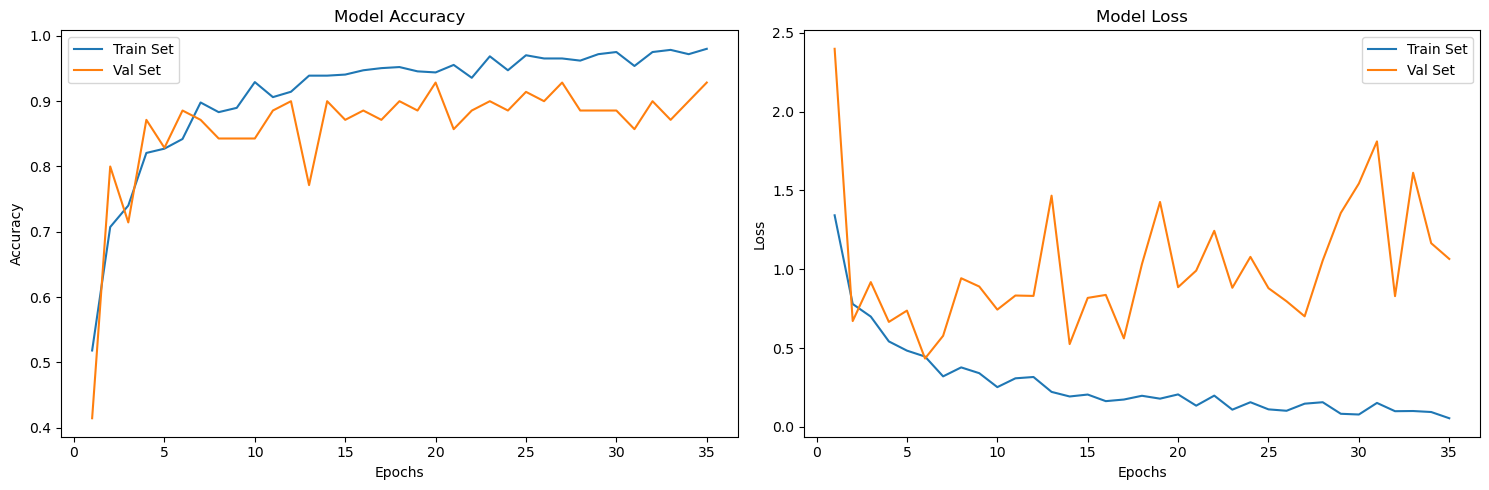

In [32]:
# Plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [40]:
def chestScanPrediction(path, model):
    classes_dir = ["Adenocarcinoma", "Large cell carcinoma", "Normal", "Squamous cell carcinoma"]

    # Loading Image
    img = image.load_img(path, target_size=(224, 224))
    # Converting Image to Numpy Array
    input_arr = image.img_to_array(img)
    # Preprocess the input image
    input_arr = preprocess_input(input_arr)
    # Adding extra dimension to match the model input shape
    input_arr = np.expand_dims(input_arr, axis=0)

    # Getting Predictions
    pred = model.predict(input_arr)
    # Converting probability to percentage
    prob = round(np.max(pred) * 100, 2)
    # Getting predicted class index
    pred_index = np.argmax(pred)
    # Getting predicted class
    pred_class = classes_dir[pred_index]

    # Returning prediction result
    return {"class": pred_class, "probability": prob}


In [43]:
# path = "chest-ctscan-images/Data/test/large.cell.carcinoma/000110.png"
# path = "chest-ctscan-images/Data/test/adenocarcinoma/000114.png"
path = "chest-ctscan-images/Data/test/squamous.cell.carcinoma/000119.png"
# path = "chest-ctscan-images/Data/test/normal/7.png"
chestScanPrediction(path, model_mobnet)

1/1 [==============================] - 0s 95ms/step


{'class': 'Squamous cell carcinoma', 'probability': 99.99}